In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

In [7]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install tensorflow

  Using cached tensorflow-2.17.0-cp312-cp312-win_amd64.whl.metadata (3.2 kB)
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.17.0-cp312-cp312-win_amd64.whl (2.0 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Cell 1: Data Preparation and Data Generators

import os
import json
import numpy as np
import random
from PIL import Image
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

# Parameters
image_folder = r'C:\Users\Hisoka\Desktop\grat\VG_100K'
max_length = 128
image_size = (224, 224)
sample_size = 10000
batch_size = 16

# Initialize tokenizer and label encoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder = LabelEncoder()

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Function to tokenize and pad sequences
def tokenize_and_pad(data, max_length):
    if not data:
        return np.zeros((0, max_length)), np.zeros((0, max_length))
    encodings = tokenizer(data, truncation=True, padding='max_length', max_length=max_length, return_tensors="np")
    return encodings['input_ids'], encodings['attention_mask']

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(image_size)
        image = np.array(image) / 255.0
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((*image_size, 3))

# Paths to JSON files
region_description_file = r'C:\Users\Hisoka\Desktop\grat\region_descriptions.json'
objects_file = r'C:\Users\Hisoka\Desktop\grat\objects.json'
relationships_file = r'C:\Users\Hisoka\Desktop\grat\relationships.json'
attributes_file = r'C:\Users\Hisoka\Desktop\grat\attributes.json'
qa_file = r'C:\Users\Hisoka\Desktop\grat\question_answers.json'

# Load data
region_description = load_json(region_description_file)
objects = load_json(objects_file)
relationships = load_json(relationships_file)
attributes = load_json(attributes_file)
qa = load_json(qa_file)

# Helper functions to extract image_ids
def extract_image_ids(data, id_key):
    return [item[id_key] for item in data if id_key in item]

# Get all image IDs
all_image_ids = list(set(
    extract_image_ids(region_description, 'image_id') + 
    extract_image_ids(objects, 'image_id') + 
    extract_image_ids(relationships, 'image_id') + 
    extract_image_ids(attributes, 'image_id') + 
    extract_image_ids(qa, 'id')
))

# Randomly sample 10,000 image IDs
if len(all_image_ids) > sample_size:
    sampled_image_ids = random.sample(all_image_ids, sample_size)
else:
    sampled_image_ids = all_image_ids

# Filter data based on sampled image IDs
def filter_data_by_image_ids(data, image_ids, id_key='image_id'):
    return [item for item in data if id_key in item and item[id_key] in image_ids]

region_description = filter_data_by_image_ids(region_description, sampled_image_ids, id_key='image_id')
objects = filter_data_by_image_ids(objects, sampled_image_ids, id_key='image_id')
relationships = filter_data_by_image_ids(relationships, sampled_image_ids, id_key='image_id')
attributes = filter_data_by_image_ids(attributes, sampled_image_ids, id_key='image_id')
qa = filter_data_by_image_ids(qa, sampled_image_ids, id_key='id')

# Preprocess data
def preprocess_data(json_data, text_key, phrase_key='phrase'):
    text_data = []
    for item in json_data:
        for entry in item.get(text_key, []):
            text_data.append(entry.get(phrase_key, ""))
    return text_data

region_phrases = preprocess_data(region_description, 'regions')
object_names = [name for sublist in preprocess_data(objects, 'objects', phrase_key='names') for name in sublist]
relationship_predicates = preprocess_data(relationships, 'relationships', phrase_key='predicate')
attribute_phrases = preprocess_data(attributes, 'attributes')
questions = [qa_pair['question'] for item in qa for qa_pair in item.get('qas', [])]
answers = [qa_pair['answer'] for item in qa for qa_pair in item.get('qas', [])]

# Tokenize and pad sequences
region_input_ids, region_attention_mask = tokenize_and_pad(region_phrases, max_length)
object_input_ids, object_attention_mask = tokenize_and_pad(object_names, max_length)
relationship_input_ids, relationship_attention_mask = tokenize_and_pad(relationship_predicates, max_length)
attribute_input_ids, attribute_attention_mask = tokenize_and_pad(attribute_phrases, max_length)
question_input_ids, question_attention_mask = tokenize_and_pad(questions, max_length)

# Encode labels
answers_encoded = label_encoder.fit_transform(answers)

# Load and preprocess images
image_data = {}
for image_id in sampled_image_ids:
    image_path = os.path.join(image_folder, f"{image_id}.jpg")
    image_data[image_id] = load_and_preprocess_image(image_path, image_size)

# Combine features for each image
combined_features = {}
for image_id in sampled_image_ids:
    combined_features[image_id] = {
        'image': image_data.get(image_id, np.zeros((*image_size, 3))),
        'region_input_ids': np.zeros((1, max_length)),
        'region_attention_mask': np.zeros((1, max_length)),
        'object_input_ids': np.zeros((1, max_length)),
        'object_attention_mask': np.zeros((1, max_length)),
        'relationship_input_ids': np.zeros((1, max_length)),
        'relationship_attention_mask': np.zeros((1, max_length)),
        'attribute_input_ids': np.zeros((1, max_length)),
        'attribute_attention_mask': np.zeros((1, max_length)),
        'question_input_ids': np.zeros((1, max_length)),
        'question_attention_mask': np.zeros((1, max_length))
    }

for idx, d in enumerate(region_description):
    combined_features[d['image_id']]['region_input_ids'][0] = region_input_ids[idx]
    combined_features[d['image_id']]['region_attention_mask'][0] = region_attention_mask[idx]

for idx, d in enumerate(objects):
    combined_features[d['image_id']]['object_input_ids'][0] = object_input_ids[idx]
    combined_features[d['image_id']]['object_attention_mask'][0] = object_attention_mask[idx]

for idx, d in enumerate(relationships):
    combined_features[d['image_id']]['relationship_input_ids'][0] = relationship_input_ids[idx]
    combined_features[d['image_id']]['relationship_attention_mask'][0] = relationship_attention_mask[idx]

for idx, d in enumerate(attributes):
    combined_features[d['image_id']]['attribute_input_ids'][0] = attribute_input_ids[idx]
    combined_features[d['image_id']]['attribute_attention_mask'][0] = attribute_attention_mask[idx]

for idx, d in enumerate(qa):
    combined_features[d['id']]['question_input_ids'][0] = question_input_ids[idx]
    combined_features[d['id']]['question_attention_mask'][0] = question_attention_mask[idx]

# Create a mapping from image_id to index in answers_encoded
image_id_to_index = {image_id: idx for idx, image_id in enumerate(sampled_image_ids)}

# Define DataGenerator class
class DataGenerator(Sequence):
    def __init__(self, image_ids, combined_features, answers_encoded, image_id_to_index, batch_size, max_length):
        self.image_ids = image_ids
        self.combined_features = combined_features
        self.answers_encoded = answers_encoded
        self.image_id_to_index = image_id_to_index
        self.batch_size = batch_size
        self.max_length = max_length

    def __len__(self):
        return len(self.image_ids) // self.batch_size

    def __getitem__(self, index):
        batch_image_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X_image = np.array([self.combined_features[image_id]['image'] for image_id in batch_image_ids])
        X_region_input_ids = np.array([self.combined_features[image_id]['region_input_ids'][0] for image_id in batch_image_ids])
        X_region_attention_mask = np.array([self.combined_features[image_id]['region_attention_mask'][0] for image_id in batch_image_ids])
        X_object_input_ids = np.array([self.combined_features[image_id]['object_input_ids'][0] for image_id in batch_image_ids])
        X_object_attention_mask = np.array([self.combined_features[image_id]['object_attention_mask'][0] for image_id in batch_image_ids])
        X_relationship_input_ids = np.array([self.combined_features[image_id]['relationship_input_ids'][0] for image_id in batch_image_ids])
        X_relationship_attention_mask = np.array([self.combined_features[image_id]['relationship_attention_mask'][0] for image_id in batch_image_ids])
        X_attribute_input_ids = np.array([self.combined_features[image_id]['attribute_input_ids'][0] for image_id in batch_image_ids])
        X_attribute_attention_mask = np.array([self.combined_features[image_id]['attribute_attention_mask'][0] for image_id in batch_image_ids])
        X_question_input_ids = np.array([self.combined_features[image_id]['question_input_ids'][0] for image_id in batch_image_ids])
        X_question_attention_mask = np.array([self.combined_features[image_id]['question_attention_mask'][0] for image_id in batch_image_ids])
        y = np.array([self.answers_encoded[self.image_id_to_index[image_id]] for image_id in batch_image_ids])
        return [
            X_image, 
            X_region_input_ids, X_region_attention_mask, 
            X_object_input_ids, X_object_attention_mask, 
            X_relationship_input_ids, X_relationship_attention_mask, 
            X_attribute_input_ids, X_attribute_attention_mask, 
            X_question_input_ids, X_question_attention_mask
        ], y

    def on_epoch_end(self):
        np.random.shuffle(self.image_ids)

# Split data into training and validation sets
train_image_ids, val_image_ids = train_test_split(sampled_image_ids, test_size=0.2, random_state=42)

# Create training and validation generators
train_generator = DataGenerator(train_image_ids, combined_features, answers_encoded, image_id_to_index, batch_size, max_length)
val_generator = DataGenerator(val_image_ids, combined_features, answers_encoded, image_id_to_index, batch_size, max_length)



In [7]:
import os
import json
import numpy as np
import random
from PIL import Image
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Attention, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import matplotlib.pyplot as plt
import time

# Parameters (ensure these match your data loading script)
image_folder = r'C:\Users\Hisoka\Desktop\grat\VG_100K'
max_length = 128
image_size = (224, 224)
batch_size = 16

# This should be set after fitting label encoder on training data
num_classes = len(label_encoder.classes_)

# Define the model
def create_model(image_shape, max_length, num_classes):
    image_input = Input(shape=image_shape, name='image_input')
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
    x = GlobalAveragePooling2D()(base_model.output)
    image_features = Dense(256, activation='relu')(x)

    def bert_layer(name):
        input_ids = Input(shape=(max_length,), name=f'{name}_input_ids', dtype=tf.int32)
        attention_mask = Input(shape=(max_length,), name=f'{name}_attention_mask', dtype=tf.int32)
        bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        for layer in bert_model.layers:
            layer.trainable = False
        bert_output = bert_model(input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = tf.reduce_mean(bert_output, axis=1)
        dense_output = Dense(256, activation='relu')(pooled_output)
        return input_ids, attention_mask, dense_output

    region_input_ids, region_attention_mask, region_features = bert_layer('region')
    object_input_ids, object_attention_mask, object_features = bert_layer('object')
    relationship_input_ids, relationship_attention_mask, relationship_features = bert_layer('relationship')
    attribute_input_ids, attribute_attention_mask, attribute_features = bert_layer('attribute')
    question_input_ids, question_attention_mask, question_features = bert_layer('question')

    def attention_mechanism(features1, features2):
        attention = Attention()([features1, features2])
        return Flatten()(attention)

    combined_features = image_features
    combined_features = attention_mechanism(combined_features, region_features)
    combined_features = attention_mechanism(combined_features, object_features)
    combined_features = attention_mechanism(combined_features, relationship_features)
    combined_features = attention_mechanism(combined_features, attribute_features)
    combined_features = attention_mechanism(combined_features, question_features)

    combined_output = Dense(256, activation='relu')(combined_features)
    combined_output = Dropout(0.5)(combined_output)
    final_output = Dense(num_classes, activation='softmax')(combined_output)

    model = Model(inputs=[
        image_input,
        region_input_ids, region_attention_mask,
        object_input_ids, object_attention_mask,
        relationship_input_ids, relationship_attention_mask,
        attribute_input_ids, attribute_attention_mask,
        question_input_ids, question_attention_mask
    ], outputs=final_output)
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the model
image_shape = (224, 224, 3)
model = create_model(image_shape, max_length, num_classes)

# Train the model with epoch timing
class TimeHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} took {time.time() - self.start_time:.2f} seconds")

time_callback = TimeHistory()
history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[time_callback])

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
500/500 [==============================] - 7873s 16s/step - loss: 8.4819 - accuracy: 0.0476 - val_loss: 7.8536 - val_accuracy: 0.0530
Epoch 2/10
500/500 [==============================] - 9381s 19s/step - loss: 7.4627 - accuracy: 0.0519 - val_loss: 7.9037 - val_accuracy: 0.0530
Epoch 3/10
148/500 [=======>......................] - ETA: 1:34:12 - loss: 7.2483 - accuracy: 0.0549

KeyboardInterrupt: 

In [ ]:
# Cell 2: Model Definition and Training

from tensorflow.keras.applications import ResNet50
from transformers import TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

# Define the model
def create_model(image_shape, max_length, num_classes):
    # Image input and processing
    image_input = Input(shape=image_shape, name='image_input')
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
    x = GlobalAveragePooling2D()(base_model.output)
    image_features = Dense(512, activation='relu')(x)
    image_features = Dropout(0.5)(image_features)

    # BERT model and text processing
    def bert_layer(name):
        input_ids = Input(shape=(max_length,), name=f'{name}_input_ids', dtype=tf.int32)
        attention_mask = Input(shape=(max_length,), name=f'{name}_attention_mask', dtype=tf.int32)
        bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        bert_model.trainable = True  # Ensure BERT layers are trainable
        bert_output = bert_model(input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = tf.reduce_mean(bert_output, axis=1)
        dense_output = Dense(512, activation='relu')(pooled_output)
        dense_output = Dropout(0.5)(dense_output)
        return input_ids, attention_mask, dense_output

    # Define inputs and outputs for each modality
    region_input_ids, region_attention_mask, region_features = bert_layer('region')
    object_input_ids, object_attention_mask, object_features = bert_layer('object')
    relationship_input_ids, relationship_attention_mask, relationship_features = bert_layer('relationship')
    attribute_input_ids, attribute_attention_mask, attribute_features = bert_layer('attribute')
    question_input_ids, question_attention_mask, question_features = bert_layer('question')

    # Combine features
    combined_features = tf.concat([
        image_features, region_features, object_features,
        relationship_features, attribute_features, question_features
    ], axis=-1)

    combined_output = Dense(512, activation='relu')(combined_features)
    combined_output = Dropout(0.5)(combined_output)
    final_output = Dense(num_classes, activation='softmax')(combined_output)

    model = Model(inputs=[
        image_input,
        region_input_ids, region_attention_mask,
        object_input_ids, object_attention_mask,
        relationship_input_ids, relationship_attention_mask,
        attribute_input_ids, attribute_attention_mask,
        question_input_ids, question_attention_mask
    ], outputs=final_output)

    model.compile(optimizer=Adam(learning_rate=3e-5),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Initialize the model
model = create_model((224, 224, 3), 128, len(label_encoder.classes_))

# Print model summary to check the architecture
model.summary()

# Define a callback for timing
class TimeHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} took {time.time() - self.start_time:.2f} seconds")

time_callback = TimeHistory()

# Implement a reduced dataset for faster training
train_generator_small = DataGenerator(train_image_ids[:1000], combined_features, answers_encoded, image_id_to_index, batch_size, max_length)
val_generator_small = DataGenerator(val_image_ids[:200], combined_features, answers_encoded, image_id_to_index, batch_size, max_length)

# Train the model with the smaller dataset
history = model.fit(
    train_generator_small,
    validation_data=val_generator_small,
    epochs=3,
    callbacks=[time_callback]
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['image_input[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

C:\Users\Hisoka\anaconda3\envs\cpu_env\lib\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar add
  total_memory_size += weight_shape * per_param_size


Epoch 1/3
62/62 [==============================] - 8697s 138s/step - loss: 10.3379 - accuracy: 0.0020 - val_loss: 10.1399 - val_accuracy: 0.0469
Epoch 2/3


In [1]:
import json

# Paths to JSON files
region_description_file = r'C:\Users\Hisoka\Desktop\grat\region_descriptions.json'
objects_file = r'C:\Users\Hisoka\Desktop\grat\objects.json'
relationships_file = r'C:\Users\Hisoka\Desktop\grat\relationships.json'

# Function to load JSON data
def load_json(file_path, num_samples=1):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data[:num_samples]

# Load and print sample data
region_description_sample = load_json(region_description_file)
objects_sample = load_json(objects_file)
relationships_sample = load_json(relationships_file)

print("Sample from region_descriptions.json:")
print(json.dumps(region_description_sample, indent=2))

print("\nSample from objects.json:")
print(json.dumps(objects_sample, indent=2))

print("\nSample from relationships.json:")
print(json.dumps(relationships_sample, indent=2))


Sample from region_descriptions.json:
[
  {
    "regions": [
      {
        "region_id": 1382,
        "width": 82,
        "height": 139,
        "image_id": 1,
        "phrase": "the clock is green in colour",
        "y": 57,
        "x": 421
      },
      {
        "region_id": 1383,
        "width": 182,
        "height": 109,
        "image_id": 1,
        "phrase": "shade is along the street ",
        "y": 372,
        "x": 194
      },
      {
        "region_id": 1384,
        "width": 61,
        "height": 30,
        "image_id": 1,
        "phrase": "man is wearing sneakers",
        "y": 491,
        "x": 241
      },
      {
        "region_id": 1385,
        "width": 36,
        "height": 36,
        "image_id": 1,
        "phrase": "cars headlights are off",
        "y": 377,
        "x": 617
      },
      {
        "region_id": 1386,
        "width": 41,
        "height": 49,
        "image_id": 1,
        "phrase": "bikes are parked at the far edge",
        "y": 2

In [ ]:
import os
import json
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Embedding, LSTM, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical, Sequence
import matplotlib.pyplot as plt

# Parameters
image_folder = r'C:\Users\Hisoka\Desktop\grat\VG_100K'
region_description_file = r'C:\Users\Hisoka\Desktop\grat\region_descriptions.json'
objects_file = r'C:\Users\Hisoka\Desktop\grat\objects.json'
relationships_file = r'C:\Users\Hisoka\Desktop\grat\relationships.json'
image_size = (224, 224)
max_length = 50  # Maximum length of text sequences
vocab_size = 10000  # Vocabulary size for text tokenization
batch_size = 32
epochs = 10

# Function to load and preprocess captions
def load_captions(region_file, objects_file, relationships_file):
    captions = {}
    with open(region_file, 'r') as f:
        region_data = json.load(f)
        for item in region_data:
            for region in item['regions']:
                image_id = region['image_id']
                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(region['phrase'])

    with open(objects_file, 'r') as f:
        objects_data = json.load(f)
        for item in objects_data:
            image_id = item['image_id']
            if image_id not in captions:
                captions[image_id] = []
            for obj in item['objects']:
                if 'names' in obj:
                    captions[image_id].append(' '.join(obj['names']))

    with open(relationships_file, 'r') as f:
        relationships_data = json.load(f)
        for item in relationships_data:
            image_id = item['image_id']
            if image_id not in captions:
                captions[image_id] = []
            for relationship in item['relationships']:
                subject_name = relationship['subject'].get('name', '')
                predicate = relationship.get('predicate', '')
                object_name = relationship['object'].get('name', '')
                if subject_name and predicate and object_name:
                    captions[image_id].append(f"{subject_name} {predicate} {object_name}")

    return captions

# Tokenize and pad captions
def preprocess_captions(captions, max_length, vocab_size):
    tokenizer = Tokenizer(num_words=vocab_size)
    all_captions = [caption for caption_list in captions.values() for caption in caption_list]
    tokenizer.fit_on_texts(all_captions)
    sequences = {image_id: tokenizer.texts_to_sequences(caption_list) for image_id, caption_list in captions.items()}
    padded_sequences = {image_id: pad_sequences(seq_list, maxlen=max_length, padding='post') for image_id, seq_list in sequences.items()}
    return padded_sequences, tokenizer.word_index, tokenizer

# Data generator for loading images in batches
class ImageCaptionGenerator(Sequence):
    def __init__(self, image_ids, captions, image_folder, image_size, max_length, vocab_size, batch_size, tokenizer):
        self.image_ids = image_ids
        self.captions = captions
        self.image_folder = image_folder
        self.image_size = image_size
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_image_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X_images, X_sequences, y = self.__data_generation(batch_image_ids)
        return [X_images, X_sequences], y

    def on_epoch_end(self):
        np.random.shuffle(self.image_ids)

    def __data_generation(self, batch_image_ids):
        X_images = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        X_sequences = np.empty((self.batch_size, self.max_length), dtype=np.int32)
        y = np.empty((self.batch_size, self.vocab_size), dtype=np.float32)

        for i, image_id in enumerate(batch_image_ids):
            image_path = os.path.join(self.image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                image = Image.open(image_path).convert('RGB')
                image = image.resize(self.image_size)
                X_images[i,] = np.array(image) / 255.0
            else:
                X_images[i,] = np.zeros((*self.image_size, 3))

            if image_id in self.captions:
                caption_list = self.captions[image_id]
                caption = random.choice(caption_list)
                if isinstance(caption, str):  # Ensure the caption is a string
                    sequence = [self.tokenizer.word_index.get(word, 0) for word in caption.split()]
                    X_sequences[i,] = pad_sequences([sequence], maxlen=self.max_length)[0]
                    y[i,] = to_categorical([sequence[-1]], num_classes=self.vocab_size)[0]
                else:
                    X_sequences[i,] = np.zeros(self.max_length)
                    y[i,] = np.zeros(self.vocab_size)
            else:
                X_sequences[i,] = np.zeros(self.max_length)
                y[i,] = np.zeros(self.vocab_size)

        return X_images, X_sequences, y

# Load data
captions = load_captions(region_description_file, objects_file, relationships_file)
all_image_ids = list(captions.keys())
captions, word_index, tokenizer = preprocess_captions(captions, max_length, vocab_size)
X_images_train, X_images_val = train_test_split(all_image_ids, test_size=0.2, random_state=42)

# Create data generators for training and validation
train_generator = ImageCaptionGenerator(X_images_train, captions, image_folder, image_size, max_length, vocab_size, batch_size, tokenizer)
val_generator = ImageCaptionGenerator(X_images_val, captions, image_folder, image_size, max_length, vocab_size, batch_size, tokenizer)

# Define the model
def create_image_captioning_model(image_shape, max_length, vocab_size):
    # Image model
    image_input = Input(shape=image_shape)
    vgg = VGG16(include_top=False, input_tensor=image_input)
    for layer in vgg.layers:
        layer.trainable = False
    image_features = Flatten()(vgg.output)
    image_features = Dense(256, activation='relu')(image_features)

    # Sequence model
    sequence_input = Input(shape=(max_length,))
    sequence_features = Embedding(vocab_size, 256)(sequence_input)
    sequence_features = LSTM(256)(sequence_features)

    # Decoder model
    decoder_input = add([image_features, sequence_features])
    decoder = Dense(256, activation='relu')(decoder_input)
    output = Dense(vocab_size, activation='softmax')(decoder)

    model = Model(inputs=[image_input, sequence_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model

# Initialize the model
model = create_image_captioning_model((*image_size, 3), max_length, vocab_size)

# Print model summary to check the architecture
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [1]:
import json

# Paths to JSON files
region_description_file = r'C:\Users\Hisoka\Desktop\grat\question_answers.json'

# Function to load JSON data
def load_json(file_path, num_samples=1):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data[:num_samples]

# Load and print sample data
region_description_sample = load_json(region_description_file)


print("Sample from question_answers.json:")
print(json.dumps(region_description_sample, indent=2))



Sample from question_answers.json:
[
  {
    "id": 1,
    "qas": [
      {
        "a_objects": [],
        "question": "What color is the clock?",
        "image_id": 1,
        "qa_id": 986768,
        "answer": "Green.",
        "q_objects": []
      },
      {
        "a_objects": [],
        "question": "How many people are there?",
        "image_id": 1,
        "qa_id": 986769,
        "answer": "Two.",
        "q_objects": []
      },
      {
        "a_objects": [],
        "question": "What color is the man's shirt?",
        "image_id": 1,
        "qa_id": 986772,
        "answer": "Red.",
        "q_objects": []
      },
      {
        "a_objects": [],
        "question": "What are the men doing?",
        "image_id": 1,
        "qa_id": 986777,
        "answer": "Interacting.",
        "q_objects": []
      },
      {
        "a_objects": [],
        "question": "Where is the white work truck?",
        "image_id": 1,
        "qa_id": 986780,
        "answer": "Parked on 

Classified 1445322 questions.
Who: 79457 questions
What: 874079 questions
When: 50929 questions
Where: 245025 questions
Why: 38655 questions
How: 157174 questions
Other: 3 questions


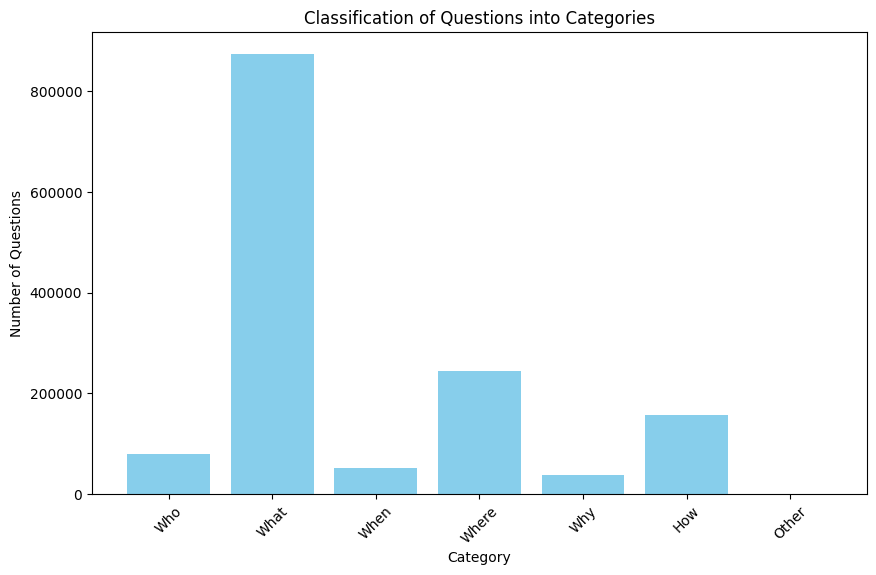

In [1]:
#1
import json
import os
import matplotlib.pyplot as plt

# Define the path to the question answers JSON file
question_answers_file = r'C:\Users\Hisoka\Desktop\grat\question_answers.json'

# Check if the file exists
if not os.path.exists(question_answers_file):
    print(f"File not found: {question_answers_file}")
else:
    # Load the question answers JSON file
    with open(question_answers_file, 'r') as f:
        data = json.load(f)

    # Define keywords for each category
    categories = {
        'Who': ['who', 'whom'],
        'What': ['what'],
        'When': ['when'],
        'Where': ['where'],
        'Why': ['why'],
        'How': ['how']
    }

    # Function to classify a question
    def classify_question(question):
        question_lower = question.lower()
        for category, keywords in categories.items():
            for keyword in keywords:
                if keyword in question_lower:
                    return category
        return 'Other'

    # Iterate through the questions and classify them
    classified_questions = []

    for item in data:
        for qa in item['qas']:
            question = qa['question']
            category = classify_question(question)
            classified_questions.append({
                'question': question,
                'category': category,
                'image_id': qa['image_id'],
                'qa_id': qa['qa_id']
            })

    # Save the classified questions to a new JSON file
    output_file = 'classified_questions.json'
    with open(output_file, 'w') as f:
        json.dump(classified_questions, f, indent=4)

    # Print a summary of the classification
    print(f"Classified {len(classified_questions)} questions.")
    category_counts = {category: 0 for category in categories}
    category_counts['Other'] = 0

    for cq in classified_questions:
        category_counts[cq['category']] += 1

    for category, count in category_counts.items():
        print(f"{category}: {count} questions")

    # Plotting the classification results
    categories_list = list(category_counts.keys())
    counts_list = list(category_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories_list, counts_list, color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Number of Questions')
    plt.title('Classification of Questions into Categories')
    plt.xticks(rotation=45)
    plt.show()


is: 450087 occurrences
color: 173913 occurrences
are: 47340 occurrences
kind: 28044 occurrences
type: 23656 occurrences


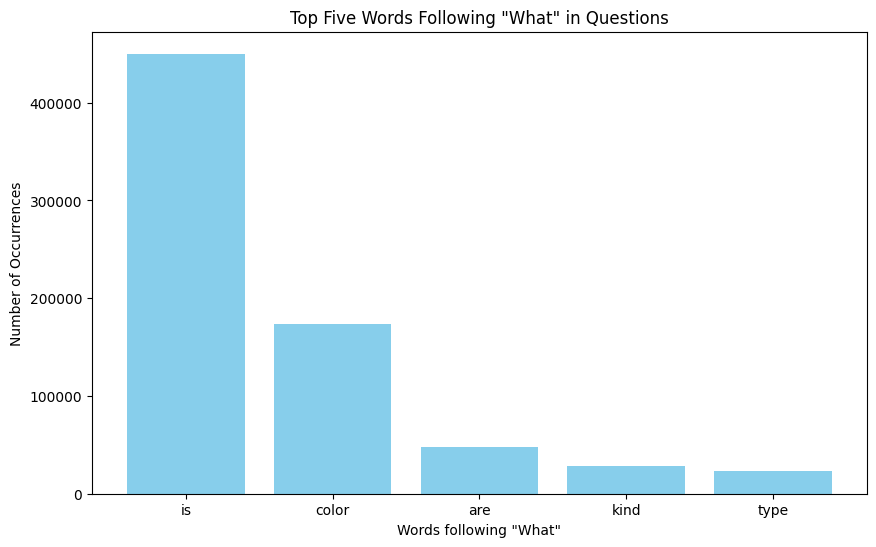

In [19]:
#2 
import json
import os
import matplotlib.pyplot as plt
from collections import Counter
import re

# Define the path to the question answers JSON file
question_answers_file = r'C:\Users\Hisoka\Desktop\grat\question_answers.json'

# Check if the file exists
if not os.path.exists(question_answers_file):
    print(f"File not found: {question_answers_file}")
else:
    # Load the question answers JSON file
    with open(question_answers_file, 'r') as f:
        data = json.load(f)

    # Define keywords for each category
    categories = {
        'Who': ['who', 'whom'],
        'What': ['what'],
        'When': ['when'],
        'Where': ['where'],
        'Why': ['why'],
        'How': ['how']
    }

    # Function to classify a question
    def classify_question(question):
        question_lower = question.lower()
        for category, keywords in categories.items():
            for keyword in keywords:
                if keyword in question_lower:
                    return category
        return 'Other'

    # Iterate through the questions and classify them
    classified_questions = []

    for item in data:
        for qa in item['qas']:
            question = qa['question']
            category = classify_question(question)
            classified_questions.append({
                'question': question,
                'category': category,
                'image_id': qa['image_id'],
                'qa_id': qa['qa_id']
            })

    # Save the classified questions to a new JSON file
    output_file = 'classified_questions.json'
    with open(output_file, 'w') as f:
        json.dump(classified_questions, f, indent=4)

    # Extract words following "what" in "What" questions
    what_questions = [cq['question'] for cq in classified_questions if cq['category'] == 'What']
    following_words = []

    for question in what_questions:
        # Use regex to find the word after "what"
        match = re.search(r'\bwhat\b\s+(\w+)', question.lower())
        if match:
            following_words.append(match.group(1))

    # Count the occurrences of the words
    word_counts = Counter(following_words)
    top_five_words = word_counts.most_common(5)

    # Print the top five words
    for word, count in top_five_words:
        print(f"{word}: {count} occurrences")

    # Plotting the top five repeated words
    words, counts = zip(*top_five_words)

    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xlabel('Words following "What"')
    plt.ylabel('Number of Occurrences')
    plt.title('Top Five Words Following "What" in Questions')
    plt.show()


In [21]:
import json

# Path to the objects JSON file
objects_file = r'C:\Users\Hisoka\Desktop\grat\objects.json'

# Function to load JSON data
def load_json(file_path, num_samples=1):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data[:num_samples]

# Load and print sample data
objects_sample = load_json(objects_file)

print("Sample from objects.json:")
print(json.dumps(objects_sample, indent=2))


Sample from objects.json:
[
  {
    "image_id": 1,
    "objects": [
      {
        "synsets": [
          "tree.n.01"
        ],
        "h": 557,
        "object_id": 1058549,
        "merged_object_ids": [],
        "names": [
          "trees"
        ],
        "w": 799,
        "y": 0,
        "x": 0
      },
      {
        "synsets": [
          "sidewalk.n.01"
        ],
        "h": 290,
        "object_id": 1058534,
        "merged_object_ids": [
          5046
        ],
        "names": [
          "sidewalk"
        ],
        "w": 722,
        "y": 308,
        "x": 78
      },
      {
        "synsets": [
          "building.n.01"
        ],
        "h": 538,
        "object_id": 1058508,
        "merged_object_ids": [],
        "names": [
          "building"
        ],
        "w": 222,
        "y": 0,
        "x": 1
      },
      {
        "synsets": [
          "street.n.01"
        ],
        "h": 258,
        "object_id": 1058539,
        "merged_object_ids": [
 

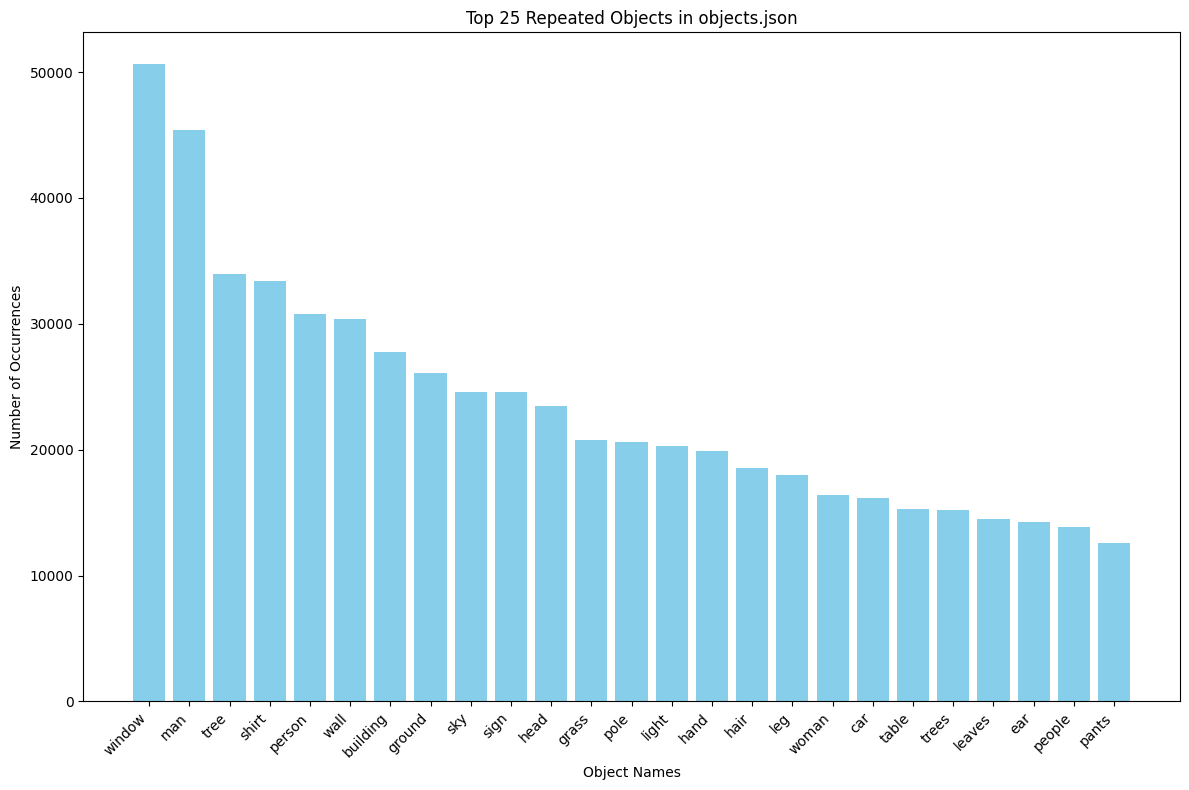

In [23]:
#3
import json
import os
import matplotlib.pyplot as plt
from collections import Counter

# Path to the objects JSON file
objects_file = r'C:\Users\Hisoka\Desktop\grat\objects.json'

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Load the objects data
objects_data = load_json(objects_file)

# Extract and count object names
object_names = []

for item in objects_data:
    for obj in item['objects']:
        object_names.extend(obj['names'])

# Count the occurrences of each object name
object_counts = Counter(object_names)

# Get the top 25 most repeated objects
top_25_objects = object_counts.most_common(25)

# Separate the object names and their counts for plotting
objects, counts = zip(*top_25_objects)

# Plotting the top 25 repeated objects
plt.figure(figsize=(12, 8))
plt.bar(objects, counts, color='skyblue')
plt.xlabel('Object Names')
plt.ylabel('Number of Occurrences')
plt.title('Top 25 Repeated Objects in objects.json')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [29]:
import json

# Path to the relationships JSON file
relationships_file = r'C:\Users\Hisoka\Desktop\grat\relationships.json'

# Function to load JSON data
def load_json(file_path, num_samples=1):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data[:num_samples]

# Load and print sample data
relationships_sample = load_json(relationships_file)

print("Sample from relationships.json:")
print(json.dumps(relationships_sample, indent=2))


Sample from relationships.json:
[
  {
    "relationships": [
      {
        "predicate": "ON",
        "object": {
          "h": 290,
          "object_id": 1058534,
          "merged_object_ids": [
            5046
          ],
          "synsets": [
            "sidewalk.n.01"
          ],
          "w": 722,
          "y": 308,
          "x": 78,
          "names": [
            "sidewalk"
          ]
        },
        "relationship_id": 15927,
        "synsets": [
          "along.r.01"
        ],
        "subject": {
          "name": "shade",
          "h": 192,
          "synsets": [
            "shade.n.01"
          ],
          "object_id": 5045,
          "w": 274,
          "y": 338,
          "x": 119
        }
      },
      {
        "predicate": "wears",
        "object": {
          "h": 28,
          "object_id": 1058525,
          "merged_object_ids": [
            5048
          ],
          "synsets": [
            "shoe.n.01"
          ],
          "w": 48,
   

In [36]:
pip install networkx


Note: you may need to restart the kernel to use updated packages.


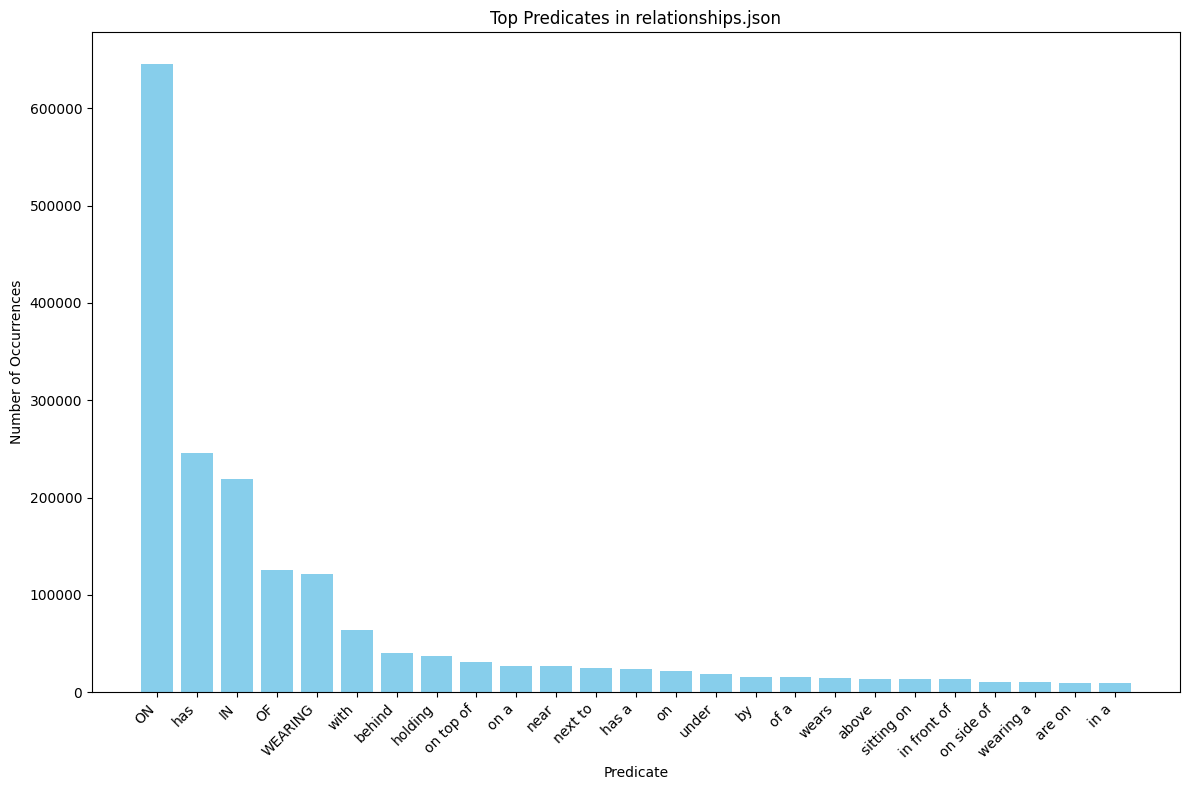

In [31]:
#4
import json
import os
import matplotlib.pyplot as plt
from collections import Counter

# Path to the relationships JSON file
relationships_file = r'C:\Users\Hisoka\Desktop\grat\relationships.json'

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Load the relationships data
relationships_data = load_json(relationships_file)

# Extract and count relationship predicates
predicates = []

for item in relationships_data:
    for relationship in item['relationships']:
        predicates.append(relationship['predicate'])

# Count the occurrences of each predicate
predicate_counts = Counter(predicates)

# Get the top 25 most repeated predicates
top_predicates = predicate_counts.most_common(25)

# Separate the predicates and their counts for plotting
predicates, counts = zip(*top_predicates)

# Plotting the top predicates
plt.figure(figsize=(12, 8))
plt.bar(predicates, counts, color='skyblue')
plt.xlabel('Predicate')
plt.ylabel('Number of Occurrences')
plt.title('Top Predicates in relationships.json')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


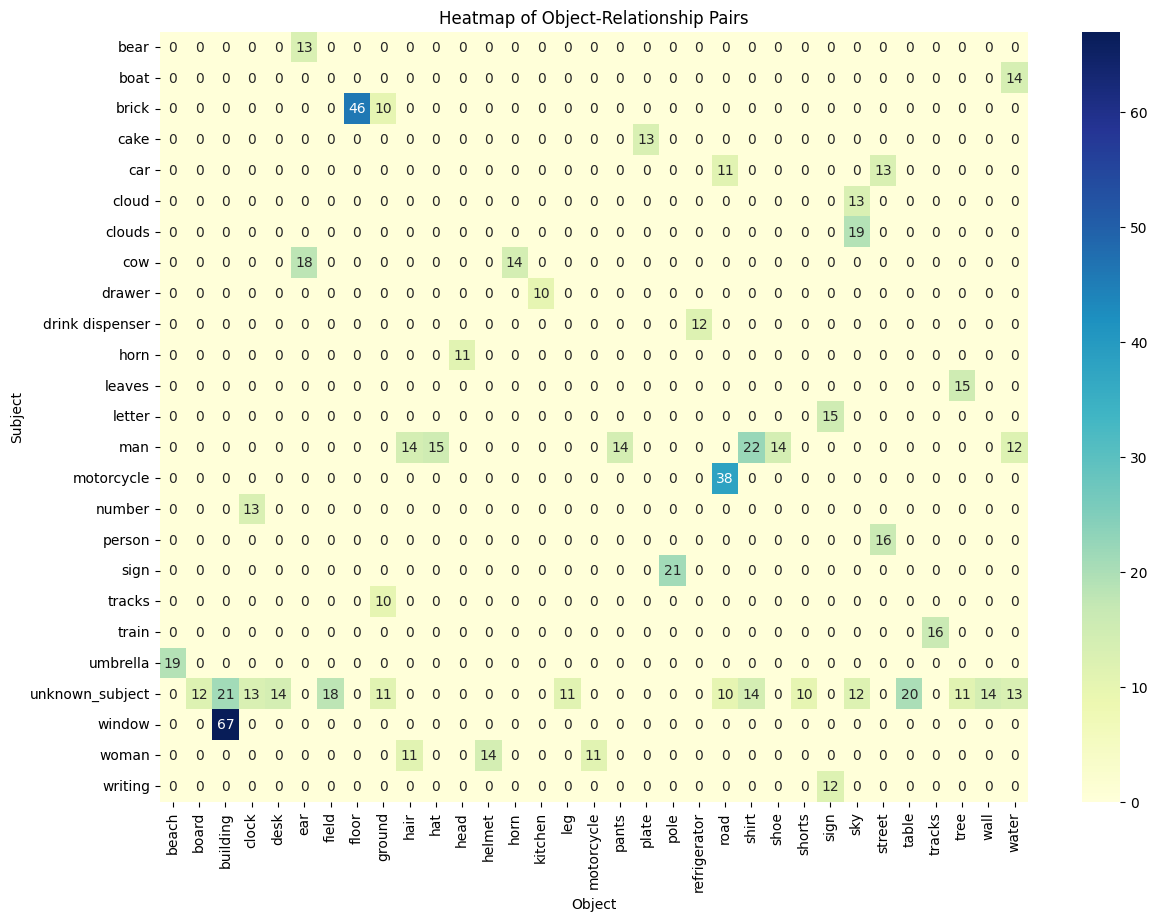

In [3]:
#code 5
#Heatmap of Object-Relationship Pairs: A heatmap showing the frequency of object-relationship pairs. For example, how often does a "man" have a "shirt" or how often is something "ON" a "sidewalk"?
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import random

# Path to the relationships JSON file
relationships_file = r'C:\Users\Hisoka\Desktop\grat\relationships.json'

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Function to sample relationships data
def sample_data(data, sample_size):
    sampled_data = random.sample(data, min(sample_size, len(data)))
    return sampled_data

# Load the relationships data
relationships_data = load_json(relationships_file)

# Sample the data to reduce the size
sample_size = 500  # Adjust sample size as needed
sampled_relationships_data = sample_data(relationships_data, sample_size)

# Extract and count object-relationship pairs
pair_counts = Counter()

for item in sampled_relationships_data:
    for relationship in item['relationships']:
        subject = relationship['subject'].get('name', 'unknown_subject')
        predicate = relationship.get('predicate', 'unknown_predicate')
        obj = relationship['object'].get('names', [relationship['object'].get('name', 'unknown_object')])[0]
        pair = (subject, predicate, obj)
        pair_counts[pair] += 1

# Get the top 50 most frequent pairs
top_pairs = pair_counts.most_common(50)

# Convert pair counts to a DataFrame for the heatmap
pairs_df = pd.DataFrame(top_pairs, columns=['Pair', 'Count'])
pairs_df[['Subject', 'Predicate', 'Object']] = pairs_df['Pair'].apply(pd.Series)
heatmap_data = pairs_df.pivot_table(index=['Subject'], columns=['Object'], values='Count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu')  # Use '.0f' to format as integers
plt.title('Heatmap of Object-Relationship Pairs')
plt.xlabel('Object')
plt.ylabel('Subject')
plt.show()


In [ ]:
#code 6 
import json
import os
import random
import nltk
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import time

# Set the NLTK data path and download 'punkt'
nltk.data.path.append(r'C:\Users\Hisoka\nltk_data')
nltk.download('punkt')

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load the datasets
question_answers_file = r'C:\Users\Hisoka\Desktop\grat\question_answers.json'
objects_file = r'C:\Users\Hisoka\Desktop\grat\objects.json'
relationships_file = r'C:\Users\Hisoka\Desktop\grat\relationships.json'
image_folder = r'C:\Users\Hisoka\Desktop\grat\VG_100K'

question_answers_data = load_json(question_answers_file)
objects_data = load_json(objects_file)
relationships_data = load_json(relationships_file)

# Extract "what" questions
what_questions = []
for item in question_answers_data:
    for qa in item['qas']:
        if qa['question'].lower().startswith('what'):
            what_questions.append({
                'image_id': qa['image_id'],
                'question': qa['question'],
                'answer': qa['answer']
            })

# Sample a subset of "what" questions to speed up processing
sample_size = 10000
sampled_what_questions = random.sample(what_questions, min(sample_size, len(what_questions)))

# Check class distribution
answer_counts = Counter([qa['answer'] for qa in sampled_what_questions])
print("Class distribution:", answer_counts)

# Tokenize and build vocabulary using NLTK
def tokenize(text):
    return nltk.word_tokenize(text.lower())

# Build vocabularies
question_tokens = [token for qa in sampled_what_questions for token in tokenize(qa['question'])]
question_vocab = {token: idx for idx, (token, _) in enumerate(Counter(question_tokens).items(), start=1)}
question_vocab['<unk>'] = 0

answer_tokens = [qa['answer'] for qa in sampled_what_questions]  # Treat full answers as tokens
answer_vocab = {token: idx for idx, token in enumerate(set(answer_tokens), start=1)}
answer_vocab['<unk>'] = 0

# Function to convert text to tensor
class TextTransform:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        return torch.tensor([self.vocab.get(token, self.vocab['<unk>']) for token in tokenize(text)])

# Initialize TextTransform for questions
question_transform = TextTransform(question_vocab)

# Define the VQA Dataset
class VQADataset(Dataset):
    def __init__(self, data, image_folder, transform=None, question_transform=None, answer_vocab=None):
        self.data = data
        self.image_folder = image_folder
        self.transform = transform
        self.question_transform = question_transform
        self.answer_vocab = answer_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.image_folder, f"{item['image_id']}.jpg")
        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            print(f"Image file {image_path} not found.")
            raise
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

        if self.transform:
            image = self.transform(image)
        question = item['question']
        answer = item['answer']
        question_tensor = self.question_transform(question)
        answer_tensor = torch.tensor(self.answer_vocab.get(answer, self.answer_vocab['<unk>']))  # Convert answer to a single integer
        return image, question_tensor, answer_tensor

# Define the transforms for the images with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Create the dataset and data loader
vqa_dataset = VQADataset(sampled_what_questions, image_folder, transform=transform, 
                         question_transform=question_transform, answer_vocab=answer_vocab)

def collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)
    questions = pad_sequence(questions, batch_first=True, padding_value=0)
    answers = torch.stack(answers)
    return images, questions, answers

data_loader = DataLoader(vqa_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Define the VQA Model
class VQAModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(VQAModel, self).__init__()
        # Image feature extraction
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 512)
        # Question processing
        self.embedding = nn.Embedding(vocab_size, 300)
        self.rnn = nn.LSTM(input_size=300, hidden_size=512, num_layers=2, batch_first=True)
        # Combining features
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, image, question):
        # Image features
        image_features = self.cnn(image)
        # Question features
        question = self.embedding(question)
        question_features, _ = self.rnn(question)
        question_features = question_features[:, -1, :]  # Get the last hidden state
        # Combine features
        combined_features = torch.cat((image_features, question_features), dim=1)
        combined_features = self.fc1(combined_features)
        output = self.fc2(combined_features)
        return output

# Hyperparameters
vocab_size = len(question_vocab)
num_classes = len(answer_vocab)  # Number of unique answers
learning_rate = 0.001  # Reduced learning rate
num_epochs = 50

# Initialize the model, loss function, and optimizer
model = VQAModel(vocab_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels).item()
    accuracy = corrects / labels.size(0)
    return accuracy

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

total_start_time = time.time()
unk_count = 0  # Counter for <unk> tokens

# For storing loss and accuracy history
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    epoch_start_time = time.time()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = 0

    for batch_idx, (images, questions, answers) in enumerate(data_loader):
        images = images.to(device)
        questions = questions.to(device)
        answers = answers.to(device)

        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        accuracy = calculate_accuracy(outputs, answers)

        epoch_loss += loss.item()
        epoch_accuracy += accuracy
        num_batches += 1

        if batch_idx % 10 == 0:  # Adjust this number to print less or more frequently
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    epoch_loss /= num_batches
    epoch_accuracy /= num_batches

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_time_remaining = epoch_duration * remaining_epochs

    print(f"Finished epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.4f}, Average Accuracy: {epoch_accuracy:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds, Estimated time remaining: {estimated_time_remaining/60:.2f} minutes")

total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(f"Training completed in {total_duration/60:.2f} minutes!")

# Print the number of <unk> tokens encountered during training
print(f"Total <unk> tokens encountered: {unk_count}")

# Plot training history
def plot_history(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()
    plt.show()

plot_history(train_losses, train_accuracies)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hisoka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Class distribution: Counter({'White.': 491, 'Blue.': 296, 'Black.': 273, 'Green.': 252, 'Brown.': 190, 'Red.': 169, 'Wood.': 112, 'Trees.': 107, 'Yellow.': 106, 'Grass.': 101, 'Gray.': 86, 'Snow.': 66, 'Grey.': 59, 'Orange.': 54, 'Metal.': 52, 'Silver.': 48, 'Clouds.': 42, 'Pink.': 42, 'Black and white.': 41, 'Water.': 36, 'Pizza.': 31, 'Skiing.': 30, 'Male.': 30, 'Standing.': 28, 'Tile.': 28, 'Baseball.': 28, 'Surfing.': 28, 'Glasses.': 27, 'Walking.': 27, 'Tennis.': 26, 'A hat.': 26, 'Round.': 25, 'Tan.': 24, 'Eating.': 23, 'Train.': 23, 'A tree.': 23, 'Skateboarding.': 22, 'Glass.': 22, 'Right.': 21, 'Dirt.': 21, 'Food.': 21, 'Sand.': 21, 'Blue and white.': 21, 'Flowers.': 20, 'Red and white.': 20, 'Rocks.': 20, 'Cat.': 19, 'Sunglasses.': 19, 'Motorcycle.': 19, 'Two.': 18, 'Buildings.': 18, 'Brown and white.': 18, 'Leaves.': 18, 'Purple.': 18, 'Horse.': 18, 'A table.': 17, 'Fence.': 17, 'Sitting.': 17, 'Stripes.': 17, 'Brick.': 17, 'Hat.': 17, 'Blonde.': 17, 'Table.': 17, 'The sky.'